# Numerical integration
Refs: 
* origianl paper: https://betterprogramming.pub/torchquad-python-library-for-numerical-integration-with-gpu-acceleration-c5f1fd32163d
* different methods for integration in torchquad: https://torchquad.readthedocs.io/en/main/integration_methods.html

In [29]:
import numpy as np
import torch
import sympy as smp
import matplotlib.pyplot as plt
from torchquad import Simpson, Trapezoid, MonteCarlo, GaussLegendre, set_up_backend
from scipy.integrate import quad, nquad

In [2]:
# Enable GPU support if available and set the floating point precision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # This will print "cuda" if everything work correctly
set_up_backend("torch", data_type="float32")

13:30:57|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


cpu


c:\Users\nn7fr\anaconda3\Lib\site-packages\torch\__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


## 1D integration
Example integration

$$\int_0^{\pi / 2} \frac{\cos (x)}{1+\sin (x)} d x$$

In [8]:
# using scipy 
def integrand(x):
    return np.cos(x) / (1 + np.sin(x)) 

res = {}
res['scipyquad'], _ = quad(integrand, 0, np.pi/2)
# (0.6931471805599454, 7.695479593116622e-15)

In [9]:
def integrand_pytorch(x):
    return torch.cos(x) / (1 + torch.sin(x)) 

integrator = Simpson()  # Initialize Simpson solver
res['simpson'] = integrator.integrate(integrand_pytorch, dim=1, N=999999,
             integration_domain=[[0, np.pi/2]],
             backend="torch",)
# 0.6931

integrator = MonteCarlo()  # Initialize Simpson solver
res['montecarlo'] = integrator.integrate(integrand_pytorch, dim=1, N=999999,
             integration_domain=[[0, np.pi/2]],
             backend="torch",)
# 0.6936

integrator = GaussLegendre()  # Initialize Simpson solver
res['gausslegendre'] = integrator.integrate(integrand_pytorch, dim=1, N=8,
             integration_domain=[[0, np.pi/2]],
             backend="torch",)

c:\Users\nn7fr\anaconda3\Lib\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
c:\Users\nn7fr\anaconda3\Lib\site-packages\autoray\autoray.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return get_lib_fn(backend, fn)(*args, **kwargs)


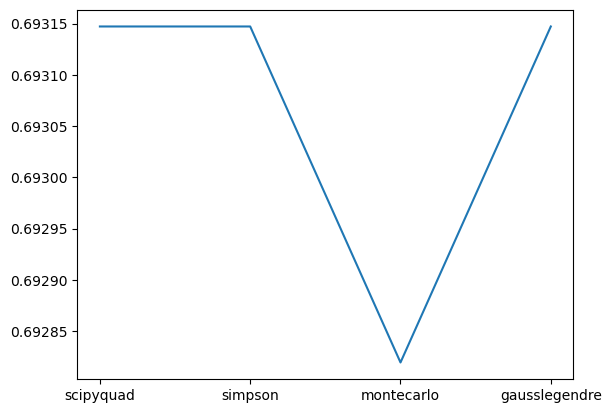

In [10]:
plt.plot(res.keys(), res.values())

## 5D equation
https://betterprogramming.pub/torchquad-python-library-for-numerical-integration-with-gpu-acceleration-c5f1fd32163d

Example integration
$$
\int_0^1 \ldots \int_0^1 \sum_{i=1}^5 \sin \left(x_i\right) d x_1 d x_2 d x_3 d x_4 d x_5
$$

In [13]:
%%timeit
def integrand(*x):
    return np.sum(np.sin(x))

res = {}
res['scipyquad'], _ = nquad(integrand, [[0, 1]] * 5)[0]
# Result: 2.2984884706593016
# Time: 31.8 s ± 594 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

15.7 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
res['scipyquad'] = 2.2984884706593016

In [15]:
def integrand_pytorch(x):
    return torch.sum(torch.sin(x), dim=1)

N = 1000000
integrator = Simpson()  # Initialize Simpson solver
res['simpson'] = integrator.integrate(integrand_pytorch, dim=5, N=N, integration_domain=[[0, 1]] * 5, backend="torch",)

integrator = MonteCarlo()  # Initialize Simpson solver
res['montecarlo'] = integrator.integrate(integrand_pytorch, dim=5, N=N,integration_domain=[[0, 1]] * 5, backend="torch",)

integrator = GaussLegendre()  # Initialize Simpson solver
res['gausslegendre'] = integrator.integrate(integrand_pytorch, dim=5, N=N,integration_domain=[[0, 1]] * 5, backend="torch",)

c:\Users\nn7fr\anaconda3\Lib\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
c:\Users\nn7fr\anaconda3\Lib\site-packages\autoray\autoray.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return get_lib_fn(backend, fn)(*args, **kwargs)


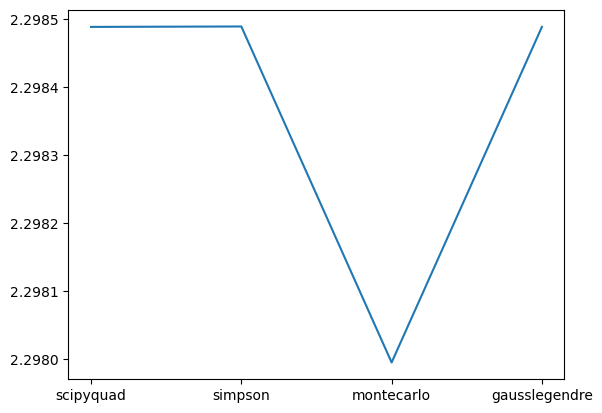

In [16]:
plt.plot(res.keys(), res.values())

## 2D integration
* https://numfactory.upc.edu/web/Calculo2/P2_Integracio/html/Integral2DQuad.html
* https://en.wikipedia.org/wiki/Simpson%27s_rule
$$
\iint_{\Omega_R} F(x, y) d x d y=\iint_{\Omega_R} x^2 y^2 d x d y=\int_{-1}^1 \int_{-1}^1 x^2 y^2 \quad d x d y=\frac{4}{9} \approx 0.44444
$$

### Sử dụng phương pháp trapedoidal

In [94]:
def create_2d_grid(a, b, c, d, M, N):
    x = torch.linspace(a, b, M)
    y = torch.linspace(c, d, N)
    Y, X = torch.meshgrid(y, x)
    return X, Y

def compute_trapezoidal_integral(f, x, y):
    # Tính toán kích thước của grid
    nx, ny = f.shape

    # Tính toán khoảng cách giữa các điểm grid
    dx = x[:, 1:] - x[:, :-1]
    dy = y[1:, :] - y[:-1, :]
    dxx = dx[0,:]
    dyy = dy[:,0]
    # Áp dụng công thức tích phân trapezoidal
    integral = 0.5 * (f[:, :-1] + f[:, 1:]) * dxx  # Tính toán phần diện tích trapezoidal dọc theo trục x
    integral = integral.sum(dim=1)  # Tính tổng các phần diện tích trapezoidal
    integral = 0.5 * (integral[:-1] + integral[1:]) * dyy  # Tính toán phần diện tích trapezoidal dọc theo trục y
    integral = integral.sum()  # Tính tổng các phần diện tích trapezoidal

    return integral

def compute_simpson_integral(f, x, y):
    # Tính toán kích thước của grid
    nx, ny = f.shape
    
    # Tính toán khoảng cách giữa các điểm grid
    dx = (x[0, 2::2] - x[0, 0:-2:2])/2
    dy = (y[2::2, 0] - y[0:-2:2, 0])/2

    # Áp dụng công thức tích phân Simpson
    integral = (f[:, 0:-2:2] + 4*f[:, 1:-1:2] + f[:, 2::2]) * dx / 3
    integral = integral.sum(dim=1) 
    integral = (integral[0:-2:2] + 4*integral[1:-1:2] + integral[2::2]) * dy / 3
    integral = integral.sum()

    return integral


In [95]:
def integrand(x,y):
    return x**2 * y**2

res = {}
res['scipyquad'], error = nquad(integrand, [[-1, 1]] * 2)

In [96]:
def integrand_pytorch(x):
    return x[:,0]**2 * x[:,1]**2

N = 1000000
integrator = Simpson()  # Initialize Simpson solver
res['simpson'] = integrator.integrate(integrand_pytorch, dim=2, N=N, integration_domain=[[-1, 1]] * 2, backend="torch",)

integrator = Trapezoid()  # Initialize Simpson solver
res['trapezoid'] = integrator.integrate(integrand_pytorch, dim=2, N=N, integration_domain=[[-1, 1]] * 2, backend="torch",)

integrator = MonteCarlo()  # Initialize Simpson solver
res['montecarlo'] = integrator.integrate(integrand_pytorch, dim=2, N=N,integration_domain=[[-1, 1]] * 2, backend="torch",)

integrator = GaussLegendre()  # Initialize Gauss quadrature
res['gausslegendre'] = integrator.integrate(integrand_pytorch, dim=2, N=8,integration_domain=[[-1, 1]] * 2, backend="torch",)

c:\Users\nn7fr\anaconda3\Lib\site-packages\torchquad\integration\simpson.py:77: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 1000 -> 999.
  warnings.warn(
c:\Users\nn7fr\anaconda3\Lib\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
c:\Users\nn7fr\anaconda3\Lib\site-packages\autoray\autoray.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return get_lib_fn(backend, fn)(*args, **kwargs)


In [100]:
def integrand2_pytorch(x,y):
    return x**2 * y**2
# Giả sử chúng ta có dữ liệu f và tọa độ grid points là các tensors torch
x,y = create_2d_grid(-1,1,-1,1,31,21)
f = integrand2_pytorch(x,y)

# Tính tích phân bằng phương pháp trapezoidal
res['mytrapezoid'] = compute_trapezoidal_integral(f, x, y)
res['mysimpson'] = compute_simpson_integral(f, x, y)
res

{'scipyquad': 0.44444444444444436,
 'simpson': tensor(0.4445),
 'trapezoid': tensor(0.4444),
 'montecarlo': tensor(0.4442),
 'gausslegendre': tensor(0.4444, dtype=torch.float64),
 'mytrapezoid': tensor(0.4477),
 'mysimpson': tensor(0.4444)}

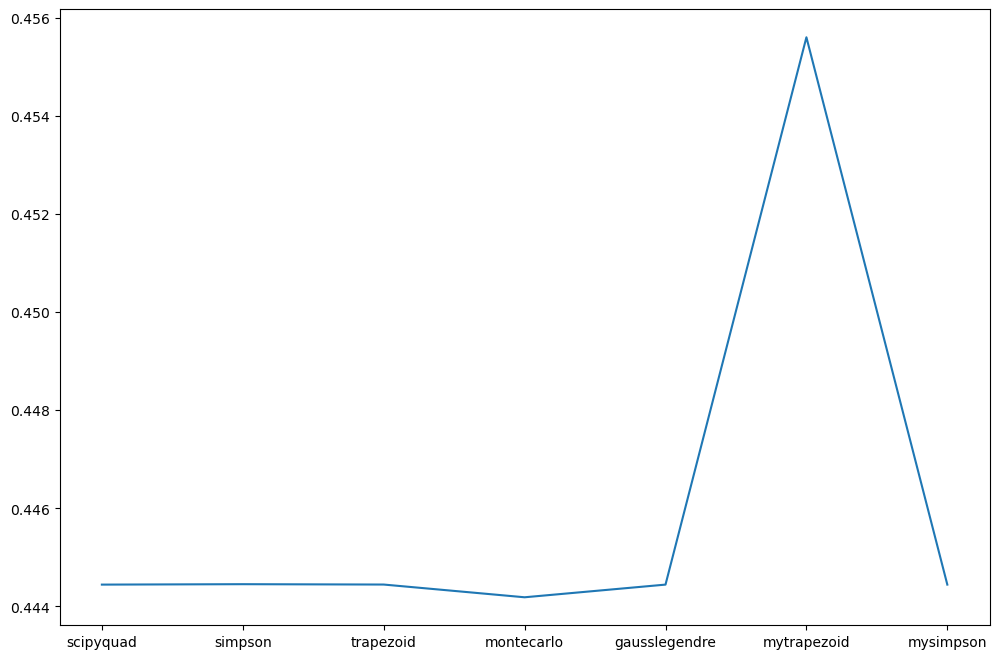

In [98]:
plt.figure(figsize=(12,8))
plt.plot(res.keys(), res.values())

In [75]:
# import torch

# def compute_trapezoidal_integral(f, x, y):
#     # Tính toán kích thước của grid
#     nx, ny = f.shape

#     # Tính toán khoảng cách giữa các điểm grid
#     dx = x[1] - x[0]
#     dy = y[1] - y[0]

#     # Áp dụng công thức tích phân trapezoidal
#     integral = 0.5 * (f[:, :-1] + f[:, 1:])  # Tính toán phần diện tích trapezoidal dọc theo trục x
#     integral = integral.sum(dim=1) * dx  # Tính tổng các phần diện tích trapezoidal và nhân với dx
#     integral = 0.5 * (integral[:-1] + integral[1:])  # Tính toán phần diện tích trapezoidal dọc theo trục y
#     integral = integral.sum() * dy  # Tính tổng các phần diện tích trapezoidal và nhân với dy

#     return integral

# # Ví dụ về cách sử dụng
# # Giả sử chúng ta có dữ liệu f và tọa độ grid points là các tensors torch
# f = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])
# x = torch.tensor([0.0, 1.0, 2.0])
# y = torch.tensor([0.0, 1.0, 2.0])

# # Tính tích phân bằng phương pháp trapezoidal
# integral = compute_trapezoidal_integral(f, x, y)
# print(integral)

In [ ]:

# Ví dụ về cách sử dụng
# Giả sử chúng ta có dữ liệu f và tọa độ grid points là các tensors torch
f = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])
x = torch.tensor([[0.0, 1.0, 2.0], [0.0, 1.0, 2.0], [0.0, 1.0, 2.0]])
y = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0], [2.0, 2.0, 2.0]])

# Tính tích phân bằng phương pháp trapezoidal
integral = compute_trapezoidal_integral(f, x, y)
print(integral)

### Sử dụng phương pháp Simpson

In [82]:
def compute_trapezoidal_integral(f, x, y):
    # Tính toán kích thước của grid
    nx, ny = f.shape

    # Tính toán khoảng cách giữa các điểm grid
    dx = x[:, 1:] - x[:, :-1]
    dy = y[1:, :] - y[:-1, :]
    dxx = dx[0,:]
    dyy = dy[:,0]
    # Áp dụng công thức tích phân trapezoidal
    integral = 0.5 * (f[:, :-1] + f[:, 1:]) * dxx  # Tính toán phần diện tích trapezoidal dọc theo trục x
    integral = integral.sum(dim=1)  # Tính tổng các phần diện tích trapezoidal
    integral = 0.5 * (integral[:-1] + integral[1:]) * dyy  # Tính toán phần diện tích trapezoidal dọc theo trục y
    integral = integral.sum()  # Tính tổng các phần diện tích trapezoidal

    return integral


# Định nghĩa hàm f = x * y
def f(x, y):
    return x**2 * y**2

# Thiết lập các thông số cho grid
a, b = -1, 1  # Miền trục x [a, b]
c, d = -1, 1  # Miền trục y [c, d]
M, N = 1001, 1001  # Kích thước grid

# Tạo grid 2D và tính toán giá trị của f
X, Y = create_2d_grid(a, b, c, d, M, N)
F = f(X, Y)

# Tính tích phân của f sử dụng phương pháp Simpson
integral = compute_simpson_integral(F, X, Y)
print(integral)

tensor(0.4444)
